In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
# Generate a dataset consisting of eight Gaussian distributions arranged in a circle.
cent = [(-0.4, 0), (-0.285, -0.285), (-0.285, 0.285), (0., -0.4), (0., 0.4), (0.285, -0.285), (0.285, 0.285), (0.4, 0)]
x_real, _= make_blobs(n_samples = 1600, n_features = 8, centers = cent, cluster_std = 0.04)

In [3]:
nD_input = x_real.shape[1]
nD_hidden = 128
nD_output = 1
nG_input = 50
nG_hidden = 128
nG_output = nD_input

In [4]:
# Build a Discriminator model
def Discriminator():
    D_in = Input(batch_shape=(None, nD_input))
    D_Ho1 = Dense(nD_hidden, activation='relu')(D_in)
    D_Ho2 = Dense(nD_hidden, activation='relu')(D_Ho1)
    D_Out = Dense(nD_output, activation='sigmoid')(D_Ho2)
    return Model(D_in, D_Out)

In [5]:
# Build a Generator model
def Generator():
    G_in = Input(batch_shape=(None, nG_input))
    G_Ho1 = Dense(nG_hidden, activation='relu')(G_in)
    G_Ho2 = Dense(nG_hidden, activation='relu')(G_Ho1)
    G_Out = Dense(nG_output)(G_Ho2)
    return Model(G_in, G_Out)

In [6]:
D = Discriminator()  # discriminator (Ψ)
S = Discriminator()  # surrogate discriminator (θ)
G = Generator()      # generator (φ)

In [13]:
# Build an unrolled GAN model using a Keras custom model
class unrolledGAN(Model):
    def __init__(self, D, S, G, k, **kwargs):
        super().__init__(**kwargs)
        self.D = D   # discriminator model
        self.S = S   # surrogate discriminator model
        self.G = G   # generator model
        self.k = k   # the number of unrolling steps
        self.D_opt = optimizers.Adam(0.0002, beta_1 = 0.5)
        self.S_opt = optimizers.Adam(0.0002, beta_1 = 0.5)
        self.G_opt = optimizers.Adam(0.0005, beta_1 = 0.5)
        self.D_loss_tracker = Mean(name="D_loss")
        self.G_loss_tracker = Mean(name="G_loss")
    
    # Copy discriminator (Ψ) to surrogate discriminator (θ)
    def copy_variables(self, src, dest):
        for i in range(len(src.variables)):
            dest.variables[i].assign(src.variables[i])            

    def lossD(self, DS, x, z):  # The loss for Discriminator (real or surrogate)
        # Clip the output values of D to prevent the loss from becoming non or inf
        Gz = self.G(z)
        Dx = tf.clip_by_value(DS(x), 1e-8, 1.0)
        DGz = tf.clip_by_value(DS(Gz), 1e-8, 0.999999)
        return -tf.reduce_mean(tf.math.log(Dx) + tf.math.log(1. - DGz))
    
    def lossG(self, DS, z):  # The loss for Generator
        Gz = self.G(z)
        DGz = tf.clip_by_value(DS(Gz), 1e-8, 0.999999)
        return tf.reduce_mean(tf.math.log(1 - DGz))
           
    @property
    def metrics(self):
        return [self.D_loss_tracker, self.G_loss_tracker]

    def train_step(self, x):
        m = tf.shape(x)[0]  # mini-batch size

        # Sample minibatch of m noise samples z from a uniform distribution
        z = tf.random.uniform((m, nG_input), -1.0, 1.0)
        # Update the discriminator (Ψ)
        with tf.GradientTape() as tape:
            d_loss = self.lossD(self.D, x, z)
        d_grads = tape.gradient(d_loss, self.D.trainable_variables)
        self.D_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        # Copy discriminator (Ψ) to surrogarate discriminator (θ)
        self.copy_variables(self.D, self.S)
        
        # Update the generator (φ)
        unrolled_grads = []
        z = tf.random.uniform((m, nG_input), -1.0, 1.0)
        for i in range(self.k):
            # Update the surrogate discriminator (θ)
            with tf.GradientTape() as tape:
                s_loss = self.lossD(self.S, x, z)
            s_grads = tape.gradient(s_loss, self.S.trainable_variables)
            self.S_opt.apply_gradients(zip(s_grads, self.S.trainable_variables))
            
            with tf.GradientTape() as tape:
                unrolled_loss = self.lossG(self.S, z)
            grads = tape.gradient(unrolled_loss, self.G.trainable_variables)
            unrolled_grads.append(grads)
        
        mean_grads = []
        for g in zip(*unrolled_grads):
            mean_grads.append(tf.reduce_mean(g, axis=0))
        self.G_opt.apply_gradients(zip(mean_grads, self.G.trainable_variables))            
               
        # Compute our own metrics
        self.D_loss_tracker.update_state(self.lossD(self.D, x, z))
        self.G_loss_tracker.update_state(self.lossG(self.D, z))
        
        return {"D_loss": self.D_loss_tracker.result(), "G_loss": self.G_loss_tracker.result()}

In [14]:
model = unrolledGAN(D, S, G, k=5) # unrolling steps (k) = 5
model.compile(optimizer=Adam())


epochs = 50

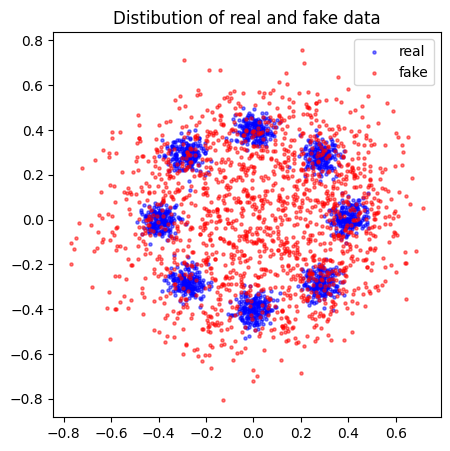


epochs = 100

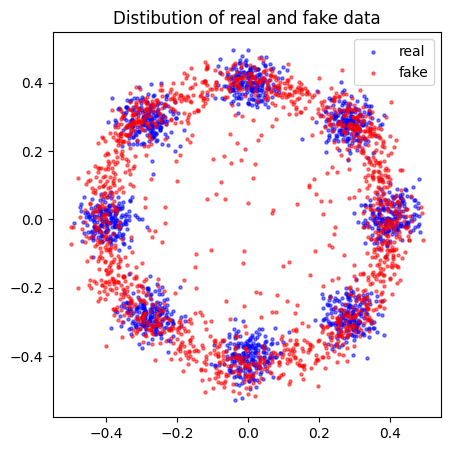


epochs = 150

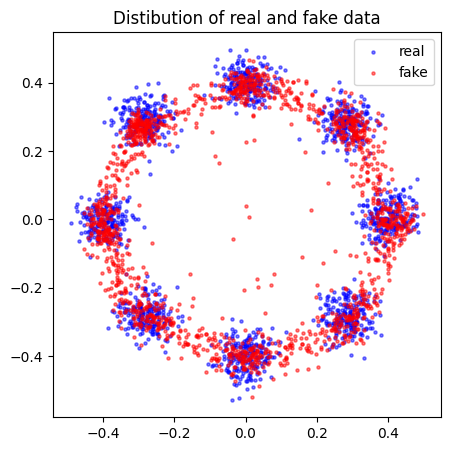


epochs = 200

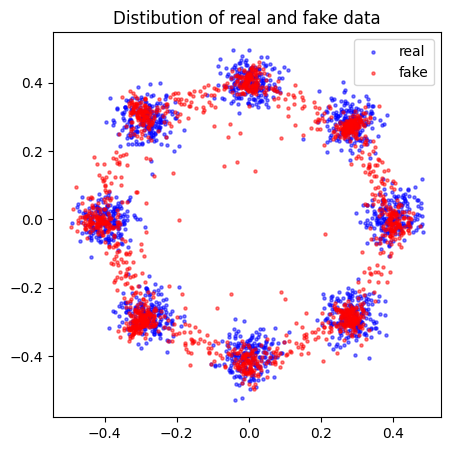


epochs = 250

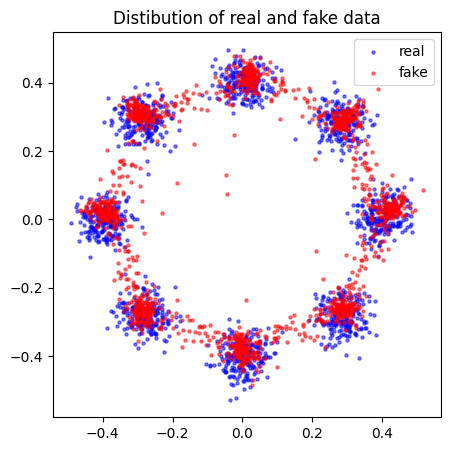


epochs = 300

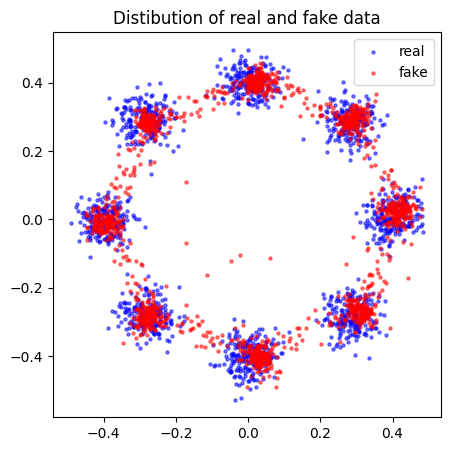


epochs = 350

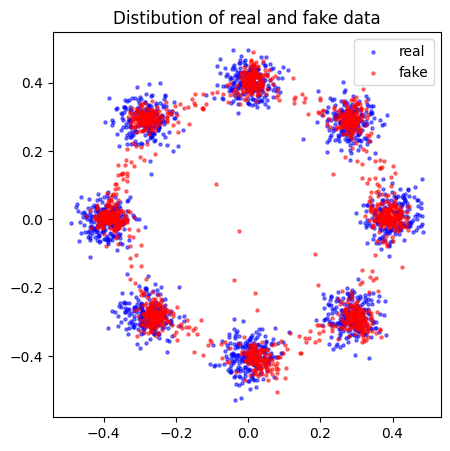


epochs = 400

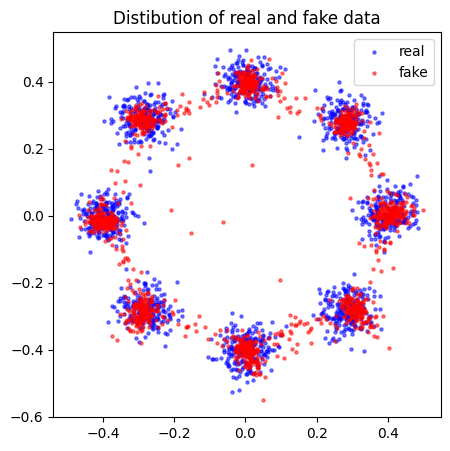


epochs = 450

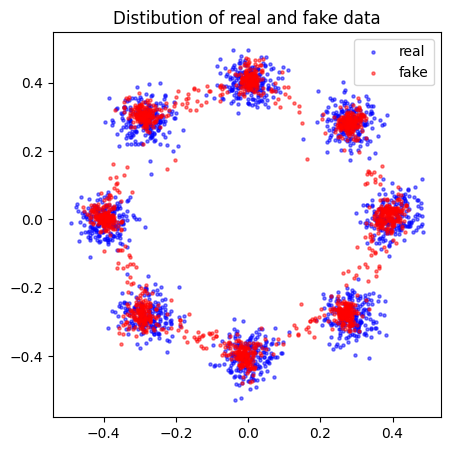


epochs = 500

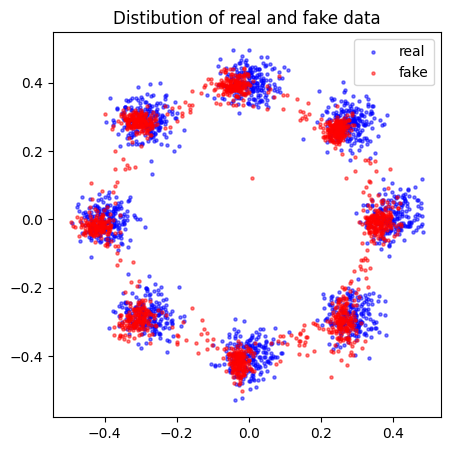


epochs = 550

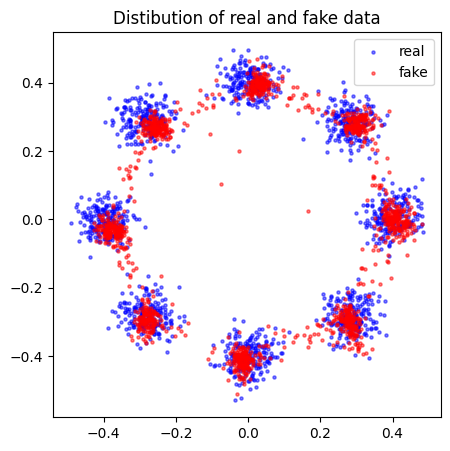


epochs = 600

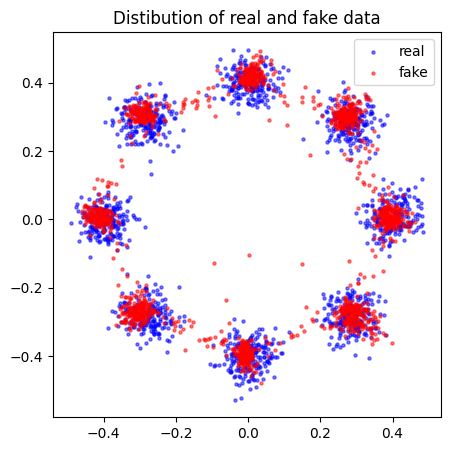


epochs = 650

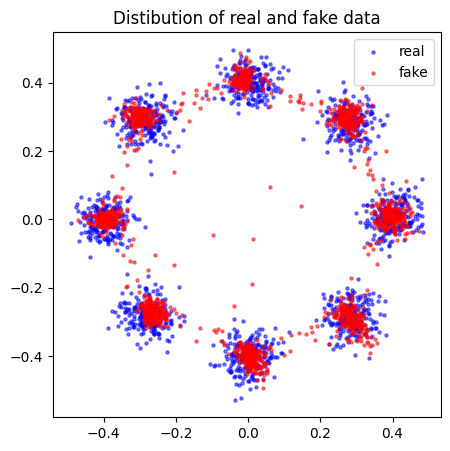


epochs = 700

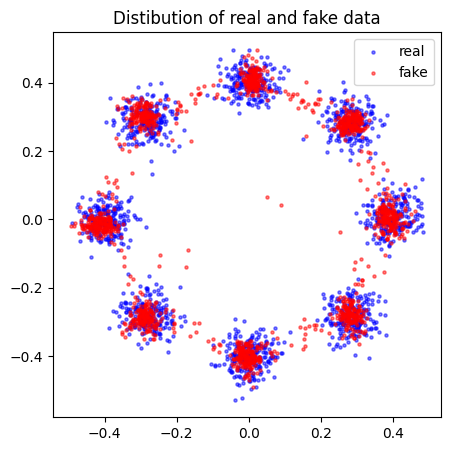


epochs = 750

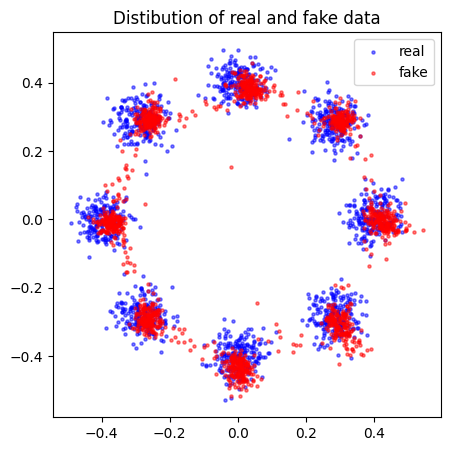


epochs = 800

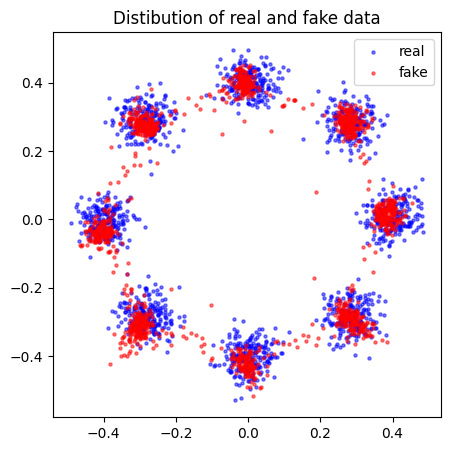


epochs = 850

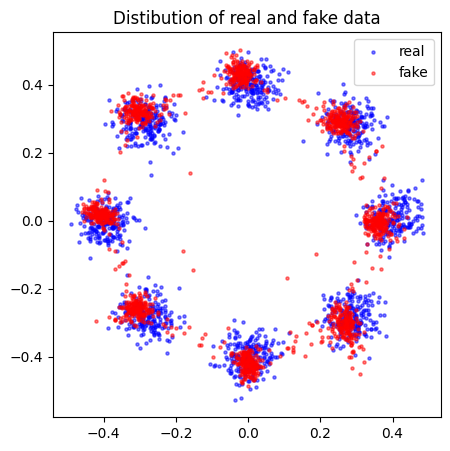


epochs = 900

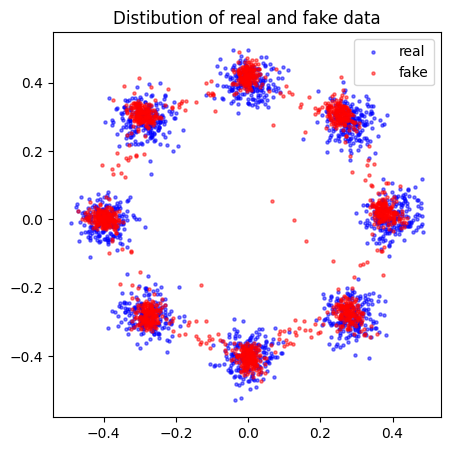


epochs = 950

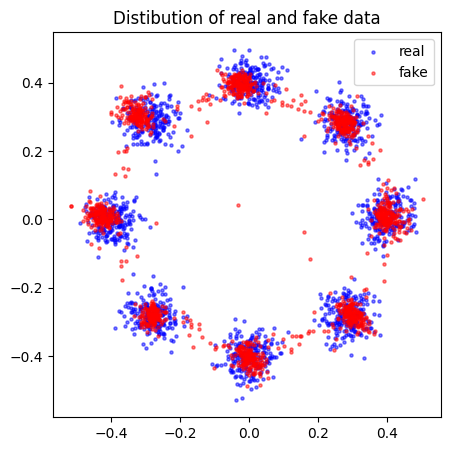


epochs = 1000

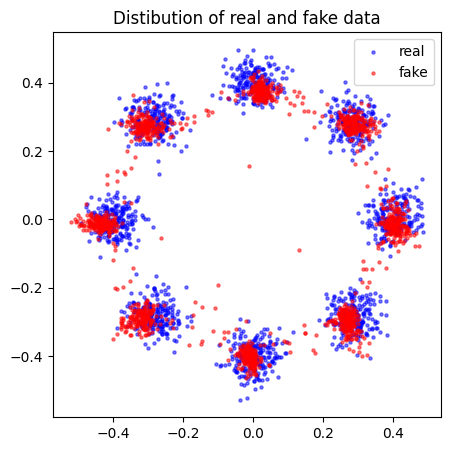

In [15]:
# Observe the distribution of the real data x and 
# the fake data G(z).
def plot_distribution():
    z = np.random.uniform(-1.0, 1.0, (x_real.shape[0], nG_input))
    x_fake = model.G(z).numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(x_real[:, 0], x_real[:, 1], c='blue', alpha=0.5, s=5, label='real')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], c='red', alpha=0.5, s=5, label='fake')
    plt.legend()
    plt.title('Distibution of real and fake data')
    plt.show()

for i in range(20):
    model.fit(x_real, epochs=50, batch_size=100, verbose=0)
    print('\nepochs =', 50 + i * 50, end='')
    plot_distribution()